In [1]:
import xarray as xr
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


def find_nearest_idx(
    arr1: np.ndarray, arr2: np.ndarray, val1: float, val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    try:
        idx = (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()
    except:
        idx = 0
    return idx

In [2]:
ds_ecland = xr.open_zarr("../tests/mock_data/ecland_cy49r2_2020_2022.zarr").sel(time=slice("2020", "2021"))
ds_ecland

<xarray.Dataset>
Dimensions:      (time: 2924, x: 10)
Coordinates:
    lat          (x) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    lon          (x) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2020-01-01 ... 2021-12-31T18:00:00
  * x            (x) int32 60870 60871 60872 60873 ... 60876 60877 60878 60879
Data variables: (12/37)
    aco2gpp      (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_CLAKE   (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_Ctype   (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cu      (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cvh     (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cvl     (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    ...           ...
    stl1         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    stl2         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    stl3         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl1        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl2        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl3        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [3]:
feat_lst = [
            'clim_CLAKE',
            'clim_Ctype',
            'clim_cu',
            'clim_cvh',
            'clim_cvl',
            'clim_geopot',
            'clim_sdfor',
            'clim_sdor',
            'clim_sotype',
            'clim_tvh',
            'clim_tvl',
            'clim_z0m',
            'lai_hv', 
            'lai_lv', 
            'met_ctpf',
            'met_lwdown',
            'met_psurf',
            'met_qair',
            'met_rainf',
            'met_swdown',
            'met_snowf',
            'met_tair',
            'met_wind_e',
            'met_wind_n',
            'swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

targ_lst = ['swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]


feats_ds = ds_ecland.isel(time=slice(0,-1))
target_ds = ds_ecland.isel(time=slice(1,None))

feats_ds = feats_ds[feat_lst].to_array().astype("float32").stack(z=("x", "time",)).transpose()
target_ds = target_ds[targ_lst].to_array().astype("float32").stack(z=("x", "time",)).transpose() - feats_ds[:, -len(targ_lst):].values

In [4]:
feats_ds

<xarray.DataArray (z: 29230, variable: 31)>
dask.array<transpose, shape=(29230, 31), dtype=float32, chunksize=(29230, 1), chunktype=numpy.ndarray>
Coordinates:
    lat       (z) float32 dask.array<chunksize=(29230,), meta=np.ndarray>
    lon       (z) float32 dask.array<chunksize=(29230,), meta=np.ndarray>
  * variable  (variable) object 'clim_CLAKE' 'clim_Ctype' ... 'stl3' 'snowc'
  * z         (z) object MultiIndex
  * x         (z) int32 60870 60870 60870 60870 ... 60879 60879 60879 60879
  * time      (z) datetime64[ns] 2020-01-01 ... 2021-12-31T12:00:00
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [115]:
%%time
X = feats_ds.values
y = target_ds.values

# Perform a split on the data reserving 20% for 
#print("Splitting test and train datasets...")
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

def r2_score_multi(y_pred, y_true):
    return r2_score(y_pred.flatten(), y_true.flatten())

model = xgb.XGBRegressor(
    n_estimators=128,
    tree_method="hist",
    objevtive=mean_absolute_percentage_error,
    #multi_strategy="multi_output_tree",
    #learning_rate=0.3,  # 0.5,
    #eval_metric=mape_multi,
    eval_metric=r2_score_multi,
    subsample=0.6,
)
print(X.shape, y.shape)
print("Fitting XGB model...")
model.fit(X, y, eval_set=[(X, y)])

(29230, 31) (29230, 7)
Fitting XGB model...
[0]	validation_0-rmse:1.19889	validation_0-r2_score_multi:0.19423
[1]	validation_0-rmse:1.04874	validation_0-r2_score_multi:0.38343
[2]	validation_0-rmse:0.92743	validation_0-r2_score_multi:0.51782
[3]	validation_0-rmse:0.84049	validation_0-r2_score_multi:0.60399
[4]	validation_0-rmse:0.78368	validation_0-r2_score_multi:0.65571
[5]	validation_0-rmse:0.73875	validation_0-r2_score_multi:0.69406
[6]	validation_0-rmse:0.70419	validation_0-r2_score_multi:0.72201
[7]	validation_0-rmse:0.67523	validation_0-r2_score_multi:0.74441
[8]	validation_0-rmse:0.65007	validation_0-r2_score_multi:0.76310
[9]	validation_0-rmse:0.62717	validation_0-r2_score_multi:0.77950
[10]	validation_0-rmse:0.61183	validation_0-r2_score_multi:0.79015
[11]	validation_0-rmse:0.59080	validation_0-r2_score_multi:0.80433
[12]	validation_0-rmse:0.57810	validation_0-r2_score_multi:0.81265
[13]	validation_0-rmse:0.56153	validation_0-r2_score_multi:0.82324
[14]	validation_0-rmse:0.551

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function r2_score_multi at 0x14ffbc71adc0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=128, n_jobs=None,
             num_parallel_tree=None,
             objevtive=<function mean_absolute_percentage_error at 0x14ffcc0c7a60>,
             predictor=None, ...)

In [116]:
# model = xgb.XGBRegressor()  # init model
# model.load_model("../../ai-land/ai-land-ens09_2015_rmse_300_gpu.json")  # load data

In [117]:
idx = find_nearest_idx(ds_ecland.isel(time=0).lat.values, ds_ecland.isel(time=0).lon.values, 51.5, 7.3)
ds_test = xr.open_zarr("../tests/mock_data/ecland_cy49r2_2020_2022.zarr")  # .sel(time="2022")
feats = ds_test[feat_lst].isel(x=idx, time=slice(0,-1))
idx

5

In [118]:
feats_arr = feats[feat_lst].to_array().values.T

In [119]:
model.predict(feats_arr[[1]])

array([[-1.4770023e-03, -9.6139690e-04, -1.5946946e-04,  1.4598068e+00,
        -1.6665083e-01, -6.8013445e-02, -4.0035928e-03]], dtype=float32)

In [120]:
%%time
for x in range(len(feats_arr)-1):
    if x % 1000 == 0:
        print(f"on step {x}...")
    preds = model.predict(feats_arr[[x]])
    feats_arr[x+1, -len(targ_lst):] = np.clip(feats_arr[x, -len(targ_lst):] + preds, 0, None)

on step 0...


on step 1000...
on step 2000...
on step 3000...
on step 4000...
CPU times: user 1.7 s, sys: 64.6 ms, total: 1.76 s
Wall time: 1.77 s


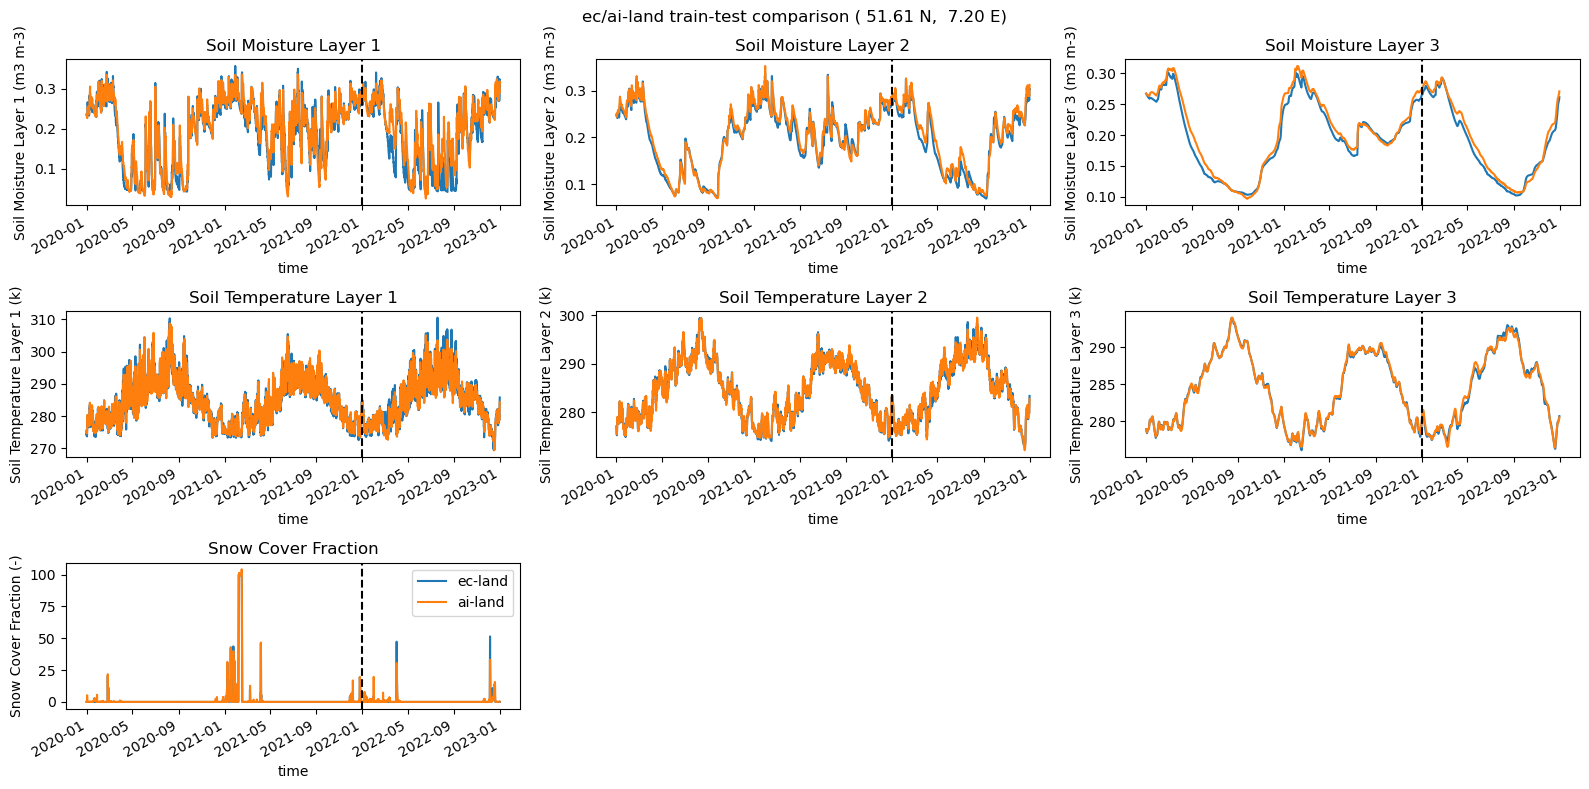

In [121]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(331)
ax1 = plt.subplot(332)
ax2 = plt.subplot(333)
ax3 = plt.subplot(334)
ax4 = plt.subplot(335)
ax5 = plt.subplot(336)
ax6 = plt.subplot(337)

feats["swvl1"].plot(label="ec-land", ax=ax)
ax.plot(feats.time, feats_arr[:, feat_lst.index("swvl1")], label="ai-land")
ax.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

feats["swvl2"].plot(label="ec-land", ax=ax1)
ax1.plot(feats.time, feats_arr[:, feat_lst.index("swvl2")], label="ai-land")
ax1.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

feats["swvl3"].plot(label="ec-land", ax=ax2)
ax2.plot(feats.time, feats_arr[:, feat_lst.index("swvl3")], label="ai-land")
ax2.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

ax.set_ylabel("Soil Moisture Layer 1 (m3 m-3)")
ax.set_title("Soil Moisture Layer 1")
ax1.set_ylabel("Soil Moisture Layer 2 (m3 m-3)")
ax1.set_title("Soil Moisture Layer 2")
ax2.set_ylabel("Soil Moisture Layer 3 (m3 m-3)")
ax2.set_title("Soil Moisture Layer 3")

feats["stl1"].plot(label="ec-land", ax=ax3)
ax3.plot(feats.time, feats_arr[:, feat_lst.index("stl1")], label="ai-land")
ax3.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

feats["stl2"].plot(label="ec-land", ax=ax4)
ax4.plot(feats.time, feats_arr[:, feat_lst.index("stl2")], label="ai-land")
ax4.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

feats["stl3"].plot(label="ec-land", ax=ax5)
ax5.plot(feats.time, feats_arr[:, feat_lst.index("stl3")], label="ai-land")
ax5.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

ax3.set_ylabel("Soil Temperature Layer 1 (k)")
ax3.set_title("Soil Temperature Layer 1")
ax4.set_ylabel("Soil Temperature Layer 2 (k)")
ax4.set_title("Soil Temperature Layer 2")
ax5.set_ylabel("Soil Temperature Layer 3 (k)")
ax5.set_title("Soil Temperature Layer 3")


feats["snowc"].plot(label="ec-land", ax=ax6)
ax6.plot(feats.time, feats_arr[:, feat_lst.index("snowc")], label="ai-land")
ax6.set_ylabel("Snow Cover Fraction (-)")
ax6.set_title("Snow Cover Fraction")
ax6.axvline(feats.sel(time="2022-01-01").time.values[0], color="k", linestyle="--")

plt.legend()
fig.suptitle(f"ec/ai-land train-test comparison ({feats.lat.values: .2f} N, {feats.lon.values: .2f} E)")
fig.tight_layout()
fig.savefig("../docs/images/ec-ai-land_comp.png", bbox_inches="tight")